In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import models
from matplotlib.lines import Line2D

import pandas as pd
import matplotlib.pyplot as plt


import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# pos=PositionalEncoding(d_model=244)
# before=torch.rand(10,32,244)
# after=pos(before)

# before=before.cpu().numpy()
# after=after.cpu().numpy()

# plt.imshow(before[:,0,:])
# plt.show()
# plt.imshow(after[:,0,:])
# plt.show()

In [ ]:
# pos=PositionalEncoding(d_model=128)
# before=torch.rand(300,32,128)
# after=pos(before)
# plt.imshow(before[:,2,:])
# plt.show()
# plt.imshow(after[:,2,:])
# plt.show()

# Data

In [4]:
class CustomStockData(Dataset):

    def __init__(self, csv_file, root_dir=None, transform=None):

        self.csv = pd.read_pickle(csv_file)

    def __len__(self):

        return len(self.csv)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        source = self.csv.iloc[idx].src
        target = self.csv.iloc[idx].trg
        initprice = self.csv.iloc[idx].initopen
        name = self.csv.iloc[idx]['name']

        sample = {'src': source, 'trg': target,
                  'initprice': initprice, 'symbol': name}

        return sample

In [5]:
data = CustomStockData('techcompdata/5yrs/srctrg_set90_30VOC_trgpad2.pkl')
trainlen = int(len(data)*0.8)
vallen = len(data)-trainlen

train, val = torch.utils.data.random_split(data, [trainlen, vallen])

trainloader = DataLoader(train, batch_size=32,
                         shuffle=True, num_workers=4)
valloader = DataLoader(val, batch_size=32,
                       shuffle=True, num_workers=4)

In [ ]:
data=CustomStockData('./processed_data/stockdset/test.pkl')
testloader = DataLoader(data, batch_size=256,
                        shuffle=True, num_workers=4)

# Model

In [6]:
Encode = models.TransformerEncoderV1(3,device,dmodel=256,layers=4,drop=.05)
Decode = models.TransformerDecoderV1(3,device,dmodel=256,layers=4,drop=.05)
Transformer = models.TransformerV1(Encode,Decode,3,dmodel=256).to(device)

In [ ]:
for name, param in Transformer.named_parameters():
    if param.dim()>1:
        nn.init.xavier_normal_(param)

In [7]:
Transformer.load_state_dict(torch.load('TransformerV4_trgpad.pt'))

<All keys matched successfully>

# Train / Eval function  

In [8]:
def plot_grad_flow(model):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in list(model.named_parameters())[:]:
        
        if(p.requires_grad) and ("bias" not in n):
#           if p.requires_grad:  
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.7, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.7, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.rcParams["figure.figsize"] = (12,6)
    plt.show()

In [9]:
def train_model(model, loss_func, opitimizer, src, trg):
    
    model.train()
    trglen = trg.shape[2]-1

    src = src.clone().detach().to(device).permute(2, 0, 1) #
    trg_input = trg.clone().detach().to(device).permute(2, 0, 1)[:-1, :, :] ##modified this line temporarily
    trg_no_sos = trg.clone().detach().to(device).permute(2, 0, 1)[1:, :, :] ##modified last dim to get rid of dummy vals


    prediction = model(src, trg_input) ###modified this line temporarily
#     prediction = prediction[:,:,:-1]
#     print(trg_input)
#     print(prediction)
#     prediction = prediction.permute(1,0)
#     trg_no_sos = trg_no_sos.permute(1,0)
    opitimizer.zero_grad()
    loss = criterion(prediction, trg_no_sos)
    loss.backward()
#     plot_grad_flow(model)
    
    opitimizer.step()
    
    return loss

In [10]:
def train_model_trgpadd(model, loss_func, opitimizer, src, trg, trgpadsize):
    
    model.train()
    trglen = trg.shape[2]-1

    src = src.clone().detach().to(device).permute(2, 0, 1) #
    trg_input = trg.clone().detach().to(device).permute(2, 0, 1)[:-1, :, :] ##modified this line temporarily
    trg_no_pad = trg.clone().detach().to(device).permute(2, 0, 1)[trgpadsize:, :, :] ##modified last dim to get rid of dummy vals


    prediction = model(src, trg_input) ###modified this line temporarily
    prediction = prediction[trgpadsize-1:, :, :]
    opitimizer.zero_grad()
    loss = criterion(prediction, trg_no_pad)
    loss.backward()
#     plot_grad_flow(model)
    
    opitimizer.step()
    
    return loss

In [11]:
def train_model_V2(model, loss_func, opitimizer, src, trg, teachforce_ratio=0):
    
    model.train()
    trglen = trg.shape[2]-1

    src = src.clone().detach().to(device).permute(2, 0, 1)
    trg_input = trg.clone().detach().to(device).permute(2, 0, 1)
    trg_no_sos = trg.clone().detach().to(
        device).permute(2, 0, 1)[1:, :, :]
    
    tgt=trg_input.clone().detach()[0,:,:].unsqueeze(0)

    for t in range(trglen):
        
        result=model(src,tgt)
        result=result[-1,:,:].unsqueeze(0)
        
        
        if np.random.random()>teachforce_ratio:
            
            tgt=torch.cat((tgt,result),dim=0)
            
        else:
            
            truth = trg_input[t+1,:,:].unsqueeze(0)
            tgt=torch.cat((tgt,truth),dim=0)
        
    opitimizer.zero_grad()
    loss = criterion(tgt[:-1,:,:], trg_no_sos)
    loss.backward()
    opitimizer.step()
    
    return loss

In [12]:
def eval_model(model, loss_func, src, trg):
    
    with torch.no_grad():
        model.eval()
        trglen = trg.shape[2]-1

        src = src.clone().detach().to(device).permute(2, 0, 1) #
        trg_input = trg.clone().detach().to(device).permute(2, 0, 1)[:-1, :, :] ##modified this line temporarily
        trg_no_sos = trg.clone().detach().to(device).permute(2, 0, 1)[1:, :, :] ##modified last dim to get rid of dummy vals


        prediction = model(src, trg_input) ###modified this line temporarily

        loss = criterion(prediction, trg_no_sos)

    return loss

In [13]:
def model_predict(model,src,trg,):
    
    src=torch.from_numpy(src).to(device)
    src=src.unsqueeze(2).permute(1,2,0)
    trg=torch.from_numpy(trg).to(device)
    trg=trg.unsqueeze(2).permute(1,2,0)
    batchsize=src.shape[1]
    trglen=trg.shape[0]-1
    
    with torch.no_grad():
        
        
        tgt=trg.clone().detach()[0,:,:].unsqueeze(0)
        
        for i in range(trglen):
            model.eval()
            result=model(src,tgt)
            result=result[-1,:,:].unsqueeze(0)
            tgt=torch.cat((tgt,result),dim=0)

    return tgt

In [14]:
def model_predictV2(model,src,trg,):
    
    src=torch.from_numpy(src).to(device)
    src=src.unsqueeze(2).permute(1,2,0)
    trg=torch.from_numpy(trg).to(device)
    trg=trg.unsqueeze(2).permute(1,2,0)
    batchsize=src.shape[1]
    trglen=trg.shape[0]-1
    
    with torch.no_grad():
        
        
        tgt=trg.clone().detach()[0,:,:].unsqueeze(0)
        
        for i in range(trglen):
            model.eval()
            result=model(src,tgt)
            result=result[-1,:,:].unsqueeze(0)
            result = torch.cat((result,torch.zeros((1,1,1),device=device)),dim=2)
            
            tgt=torch.cat((tgt,result),dim=0)
            print(tgt)

    return tgt

In [15]:
def model_predict_padtrg(model,src,trg,trgpadsize):
    
    src=torch.from_numpy(src).to(device)
    src=src.unsqueeze(2).permute(1,2,0)
    trg=torch.from_numpy(trg).to(device)
    trg=trg.unsqueeze(2).permute(1,2,0)
    trglen=trg.shape[0]-trgpadsize
    
    with torch.no_grad():
        
        
        tgt=trg.clone().detach()[:trgpadsize,:,:]
        
        for i in range(trglen):
            model.eval()
            result=model(src,tgt)
            result=result[-1,:,:].unsqueeze(0)
            
            tgt=torch.cat((tgt,result),dim=0)

    return tgt

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
from torch.optim.lr_scheduler import LambdaLR


def lambda_rule(epoch, epoch_count1=30, epoch_count2=200):
    
    lr_l = 1e-1

    if epoch-epoch_count1 < 0:
        lr_l = 1.0
        
    if epoch-epoch_count2>0:
        lr_l = 1.0
        

    return lr_l


optimizer = optim.Adam(Transformer.parameters(), lr=2e-6,)
# optimizer = optim.SGD(Transformer.parameters(), lr=1e-6, momentum=.99, weight_decay=1e-5)
scheduler = LambdaLR(optimizer, lr_lambda=lambda_rule)
criterion = nn.MSELoss()
buffertrain = []
bufferval = []
benchmark = 0.0006573313730768859

for epoch in range(20):

    start_time = time.time()

##############################################################################################################
    trainloss = 0

    for idx, sample in enumerate(trainloader):

        src = sample['src']
        trg = sample['trg']

#         trg=trg+torch.ones((32,1,8),dtype=torch.float32)*1e-8  #prevent denominator become zero
        trainloss_ = train_model_trgpadd(Transformer, criterion, optimizer, src, trg,15)
        buffertrain.append(trainloss_.item())
        trainloss += trainloss_

    trainloss = trainloss/(idx+1)

###############################################################################################################

    valloss = 0

    for idx, sample in enumerate(valloader):

        src = sample['src']
        trg = sample['trg']

#         trg=trg+torch.ones((32,1,8),dtype=torch.float32)*1e-8
        valloss_ = eval_model(Transformer, criterion, src, trg)
        bufferval.append(valloss_.item())
        valloss += valloss_

    valloss = valloss/(idx+1)

#############################################################################################################

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     scheduler.step()

    print(f'Epoch: {epoch+1} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {trainloss:.7f} | Train PPL: {math.exp(trainloss):7.3f}')
#     print(f'\t Val. Loss: {valloss:.7f} |  Val. PPL: {math.exp(valloss):7.3f}')
    print(f'\tTrain Loss: {trainloss:.7f}')
    print(f'\t Val. Loss: {valloss:.7f}')

    if valloss < benchmark:
        torch.save(Transformer.state_dict(), 'TransformerV4_trgpad.pt')
        benchmark = valloss.item()

Epoch: 1 | Time: 0m 15s
	Train Loss: 0.0001311
	 Val. Loss: 0.0006584
Epoch: 2 | Time: 0m 16s
	Train Loss: 0.0001306
	 Val. Loss: 0.0006582
Epoch: 3 | Time: 0m 16s
	Train Loss: 0.0001316
	 Val. Loss: 0.0006597
Epoch: 4 | Time: 0m 17s
	Train Loss: 0.0001315
	 Val. Loss: 0.0006597
Epoch: 5 | Time: 0m 17s
	Train Loss: 0.0001313
	 Val. Loss: 0.0006581
Epoch: 6 | Time: 0m 16s
	Train Loss: 0.0001312
	 Val. Loss: 0.0006588
Epoch: 7 | Time: 0m 16s
	Train Loss: 0.0001308
	 Val. Loss: 0.0006583
Epoch: 8 | Time: 0m 16s
	Train Loss: 0.0001305
	 Val. Loss: 0.0006605
Epoch: 9 | Time: 0m 16s
	Train Loss: 0.0001302
	 Val. Loss: 0.0006597
Epoch: 10 | Time: 0m 16s
	Train Loss: 0.0001306
	 Val. Loss: 0.0006589
Epoch: 11 | Time: 0m 16s
	Train Loss: 0.0001299
	 Val. Loss: 0.0006585
Epoch: 12 | Time: 0m 16s
	Train Loss: 0.0001307
	 Val. Loss: 0.0006584
Epoch: 13 | Time: 0m 16s
	Train Loss: 0.0001299
	 Val. Loss: 0.0006582
Epoch: 14 | Time: 0m 16s
	Train Loss: 0.0001300
	 Val. Loss: 0.0006590
Epoch: 15 | Tim

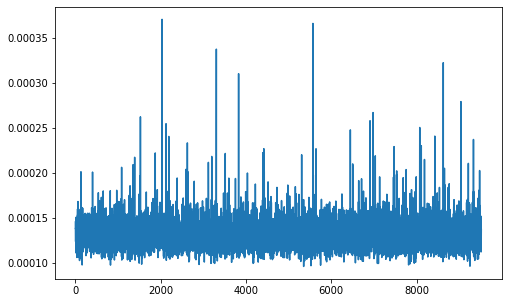

In [33]:
plt.plot([i for i in range(len(buffertrain))],buffertrain)

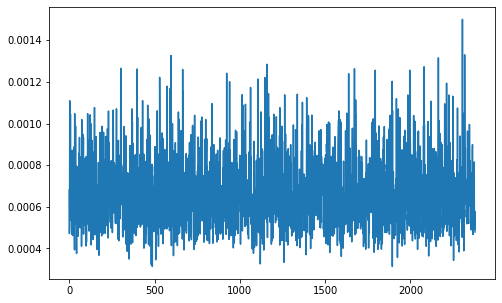

In [34]:
plt.plot([i for i in range(len(bufferval))],bufferval)

In [35]:
benchmark

0.0006573313730768859

# Draw line

In [17]:
def draw_kline_volume(src,trg,initprice):
    
    srclen=src.shape[1]
    trglen=trg.shape[1]-1
    history_price = []
    history_price.append(initprice[0])

    for gap in src[0]:
        temp = history_price[-1]+gap
        history_price.append(temp)

    for gap in trg[0][1:]:
        temp = history_price[-1]+gap
        history_price.append(temp)

    plt.plot([i for i in range(srclen+1)],
             history_price[:srclen+1], 'bs-', label='src_open_price', alpha=.6)
    plt.plot([i for i in range(srclen+1, srclen+1+trglen)],
             history_price[-trglen:], 'ro-', label='target_open_price')
    plt.title(
        f'Initial Price : {history_price[0]:.2f} || End Price : {history_price[-1]:.2f}')
    plt.legend()
    plt.grid()
    plt.show

In [18]:
def draw_line_normalized_open(src,trg,stockname,prediction,):
    
    srclen=src.shape[1]-1
    trglen=trg.shape[1]-1

    plt.plot([i for i in range(srclen)],
             src[0][1:], 'b', label='src', alpha=.6)
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             trg[0,:][1:], 'r', label='trg')
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             prediction, 'g', label='pred')
    plt.title(
        f'Stock : {stockname} Price')
    plt.legend()
    plt.grid()
    plt.rcParams["figure.figsize"] = (3,5)
    plt.show

In [19]:
def draw_line_normalized_close(src,trg,stockname,prediction):
    
    srclen=src.shape[1]-1
    trglen=trg.shape[1]-1

    plt.plot([i for i in range(srclen)],
             src[1][1:], 'b', label='src', alpha=.6)
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             trg[1,:][1:], 'r', label='trg')
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             prediction, 'g', label='pred')
    plt.title(
        f'Stock : {stockname} Close')
    plt.legend()
    plt.grid()
    plt.rcParams["figure.figsize"] = (6,12)
    plt.show

In [20]:
def draw_line_normalized_volume(src,trg,stockname,prediction):
    
    srclen=src.shape[1]-1
    trglen=trg.shape[1]-1

    plt.plot([i for i in range(srclen)],
             src[2][1:], 'b', label='src', alpha=.6)
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             trg[2,:][1:], 'r', label='trg')
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             prediction, 'g', label='pred')
    plt.title(
        f'Stock : {stockname} Volume')
    plt.legend()
    plt.grid()
    plt.rcParams["figure.figsize"] = (6,12)
    plt.show

In [21]:
def draw_line_normalized_open(src,trg,stockname,prediction,):
    
    srclen=src.shape[1]
    trglen=trg.shape[1]

    plt.plot([i for i in range(srclen)],
             src[0][:], 'b', label='src', alpha=.6)
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             trg[0,:][:], 'r', label='trg')
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             prediction, 'g', label='pred')
    plt.title(
        f'Stock : {stockname} Price')
    plt.legend()
    plt.grid()
    plt.rcParams["figure.figsize"] = (8,5)
    plt.show

In [22]:
def draw_line_normalized_close(src,trg,stockname,prediction,):
    
    srclen=src.shape[1]
    trglen=trg.shape[1]

    plt.plot([i for i in range(srclen)],
             src[1][:], 'b', label='src', alpha=.6)
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             trg[1,:][:], 'r', label='trg')
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             prediction, 'g', label='pred')
    plt.title(
        f'Stock : {stockname} Price')
    plt.legend()
    plt.grid()
    plt.rcParams["figure.figsize"] = (8,5)
    plt.show

In [23]:
def draw_line_normalized_vol(src,trg,stockname,prediction,):
    
    srclen=src.shape[1]
    trglen=trg.shape[1]

    plt.plot([i for i in range(srclen)],
             src[2][:], 'b', label='src', alpha=.6)
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             trg[2,:][:], 'r', label='trg')
    
    plt.plot([i for i in range(srclen,srclen+trglen)],
             prediction, 'g', label='pred')
    plt.title(
        f'Stock : {stockname} Price')
    plt.legend()
    plt.grid()
    plt.rcParams["figure.figsize"] = (8,5)
    plt.show

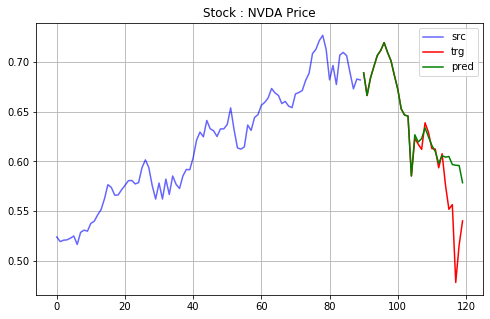

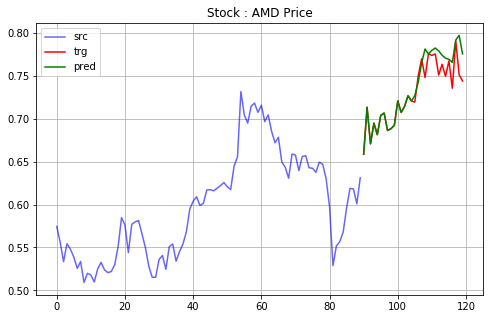

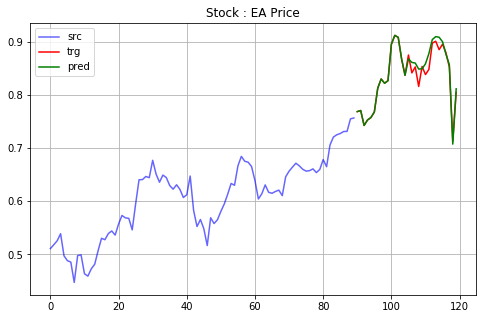

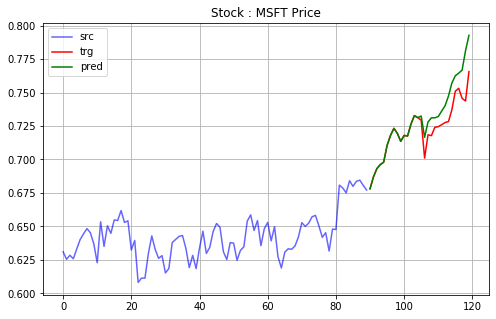

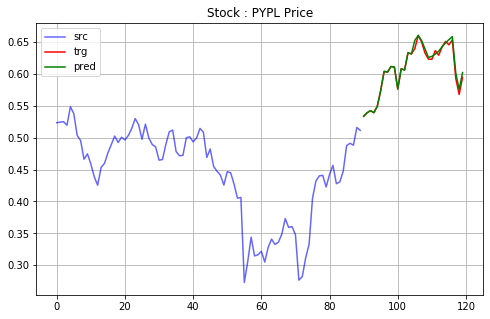

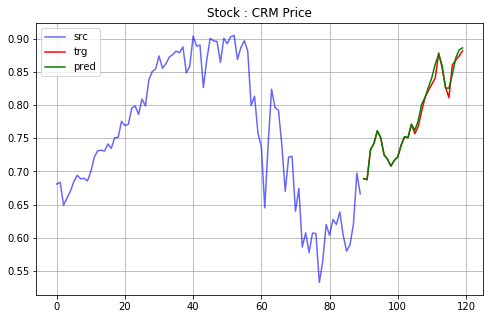

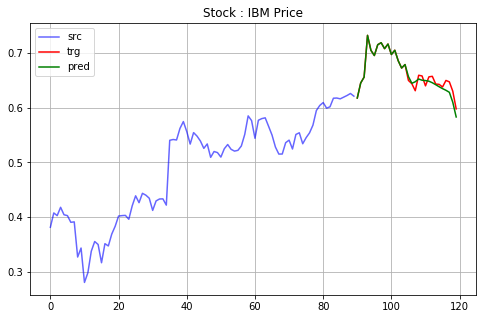

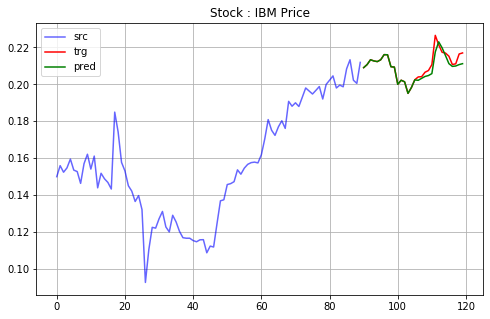

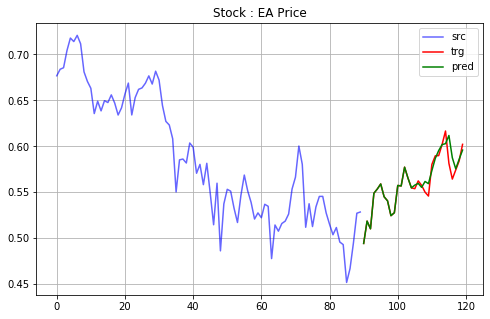

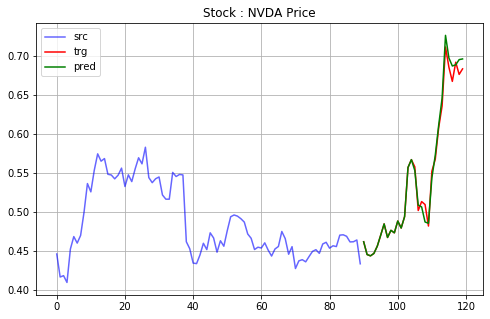

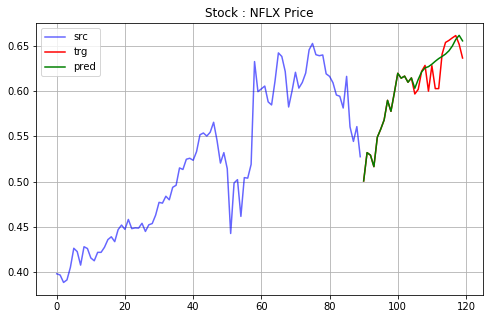

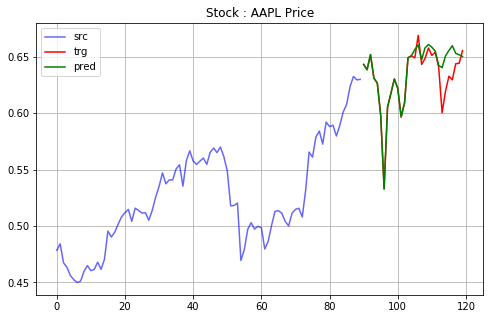

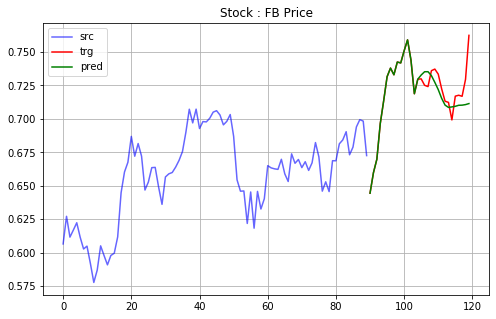

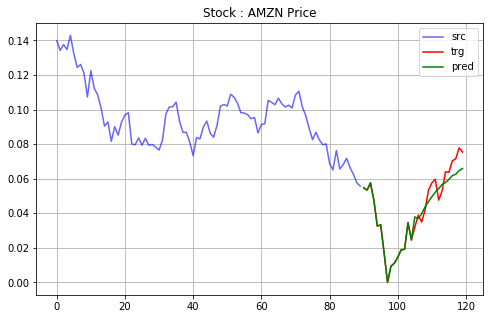

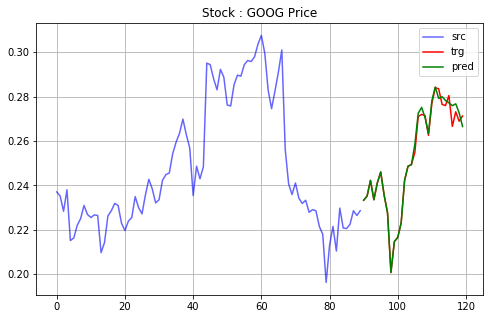

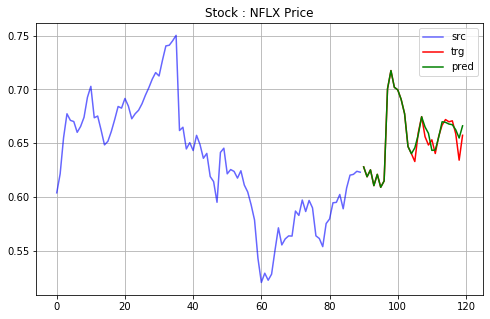

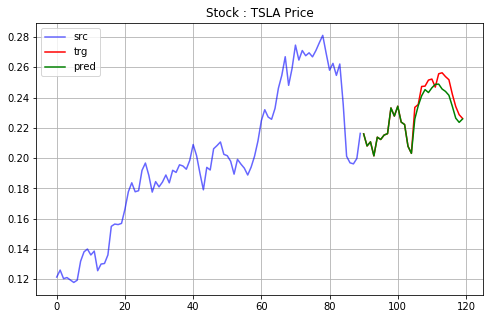

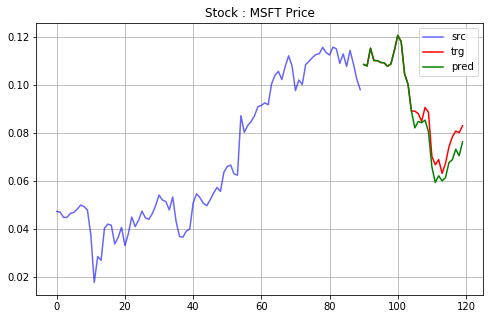

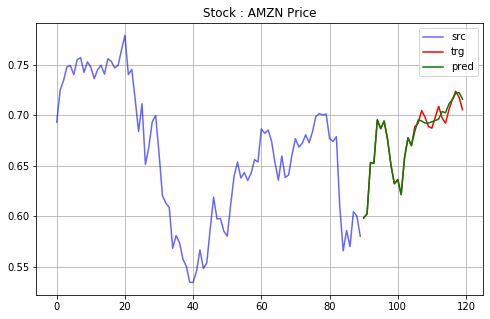

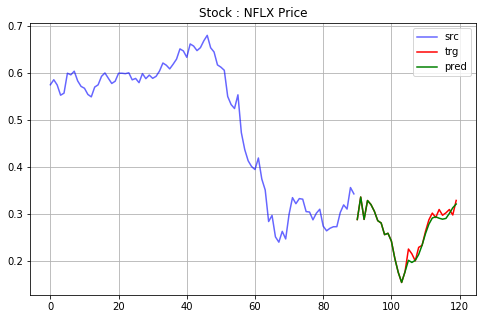

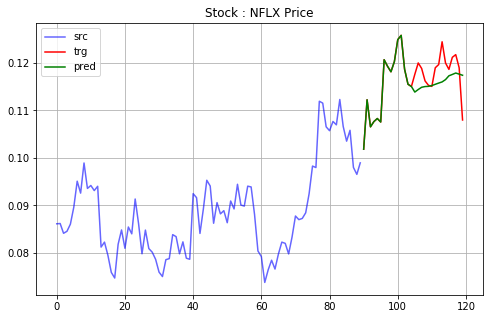

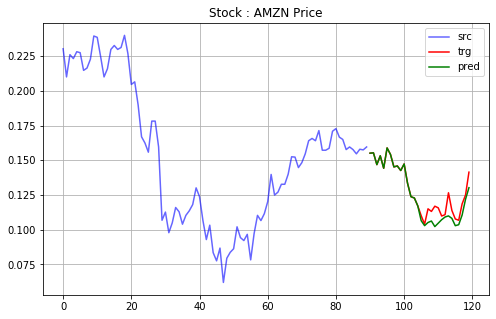

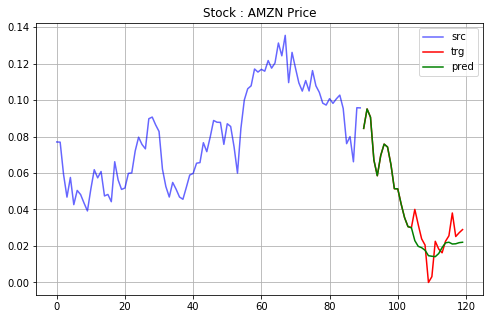

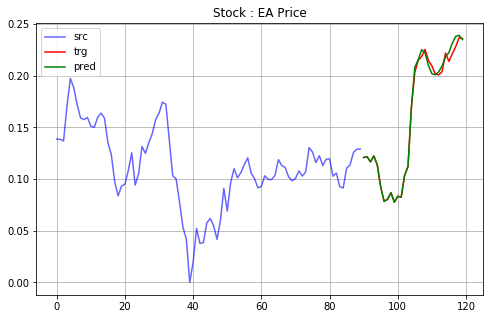

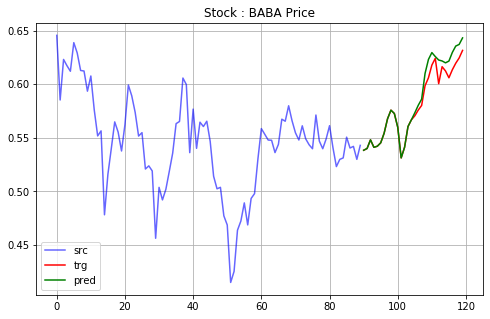

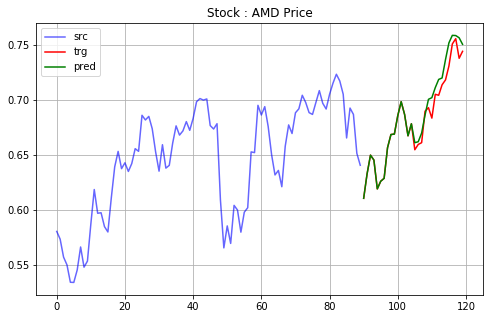

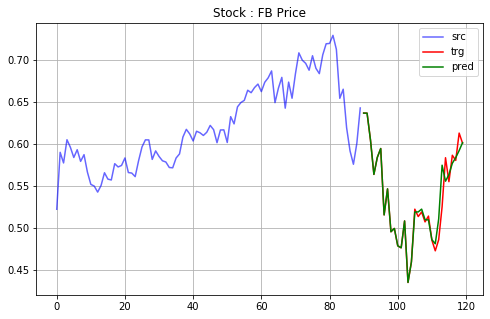

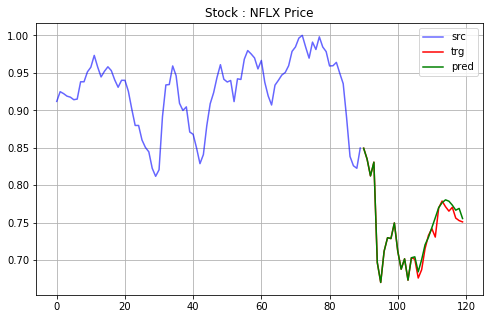

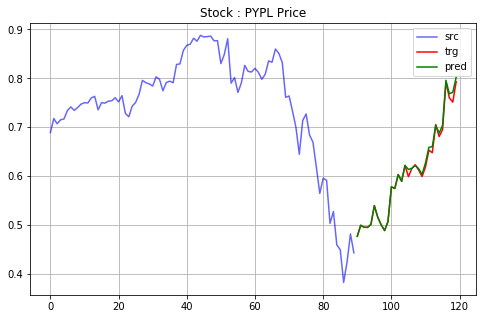

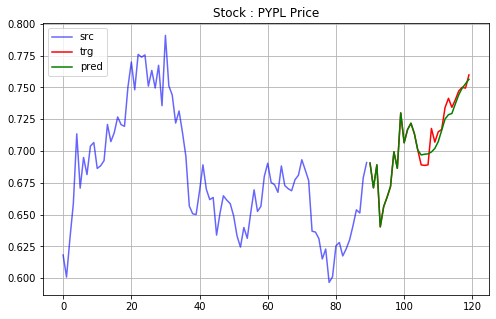

In [37]:
idx=np.random.randint(0,1000,30)

for i in idx:
    
    src = valloader.dataset[i]['src']
    trg = valloader.dataset[i]['trg']
#     print(f'trg:{trg.shape}')
    stockname = data[i]['symbol']

#     mu = stockdict[stockname]['mean'].open
#     std = stockdict[stockname]['std'].open

    prediction = model_predict_padtrg(Transformer, src, trg,15)[:, :, 0]
    prediction = prediction.squeeze(1)
    prediction = prediction.detach().cpu().numpy()

#     prediction = (prediction*std)+mu
#     src = src*std+mu
#     trg = trg*std+mu

    draw_line_normalized_open(src, trg, stockname, prediction)
    
    plt.show()

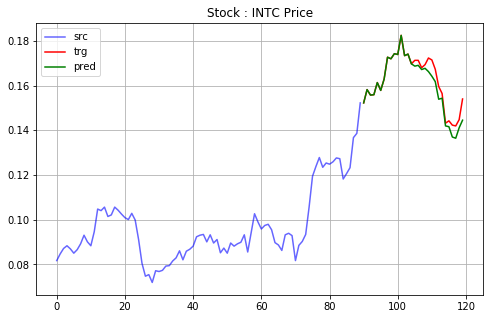

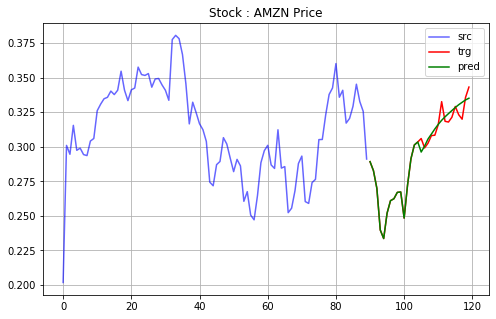

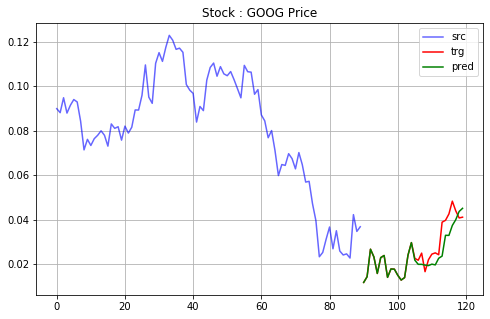

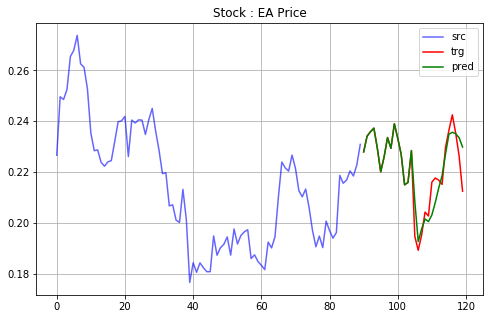

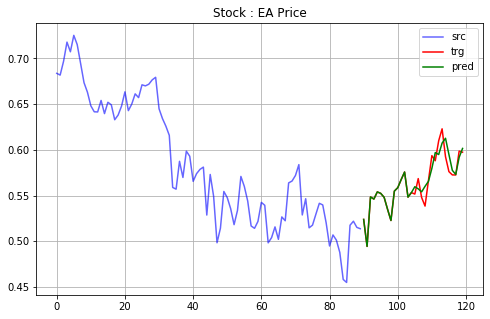

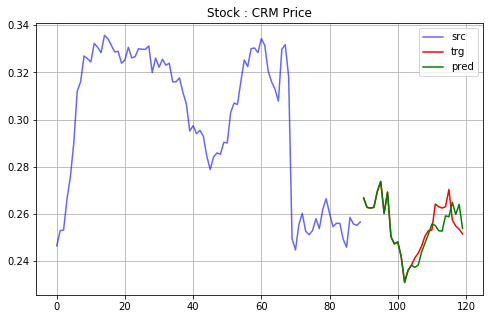

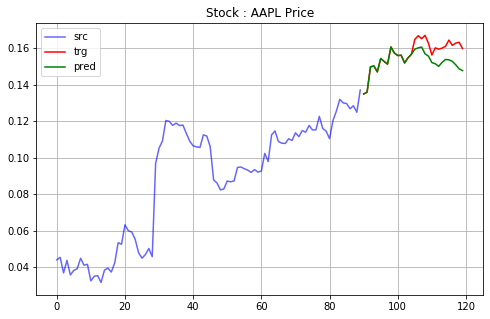

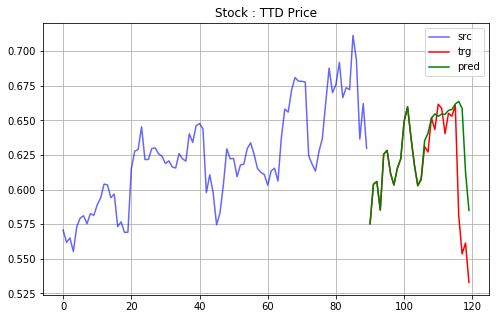

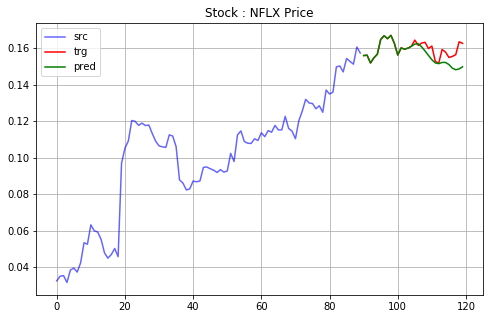

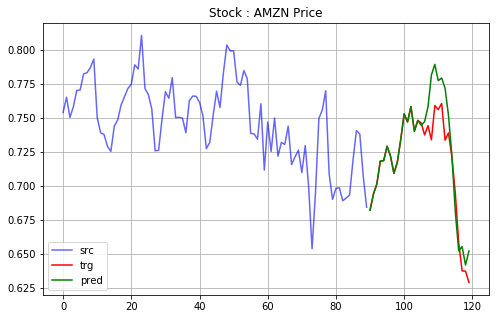

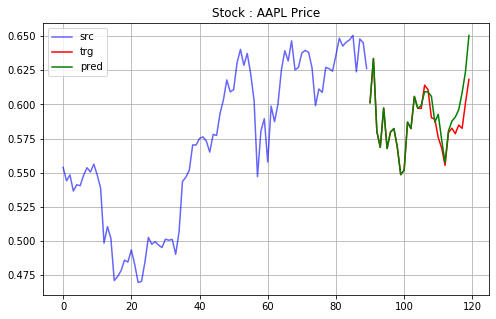

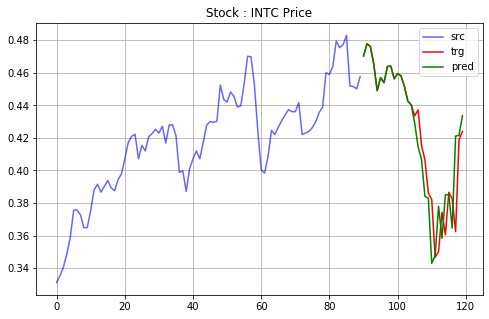

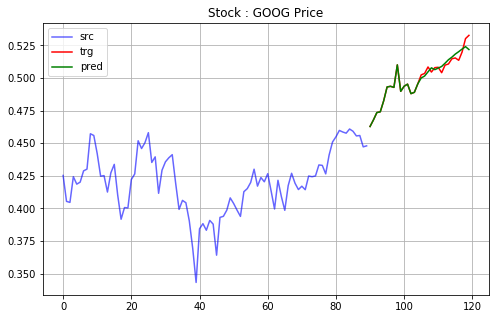

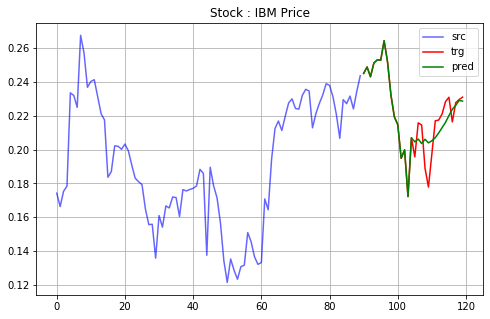

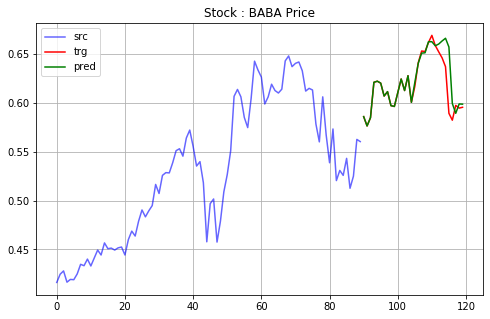

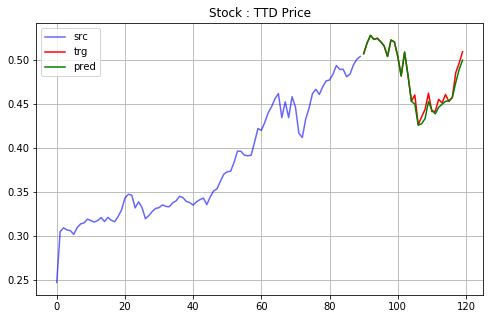

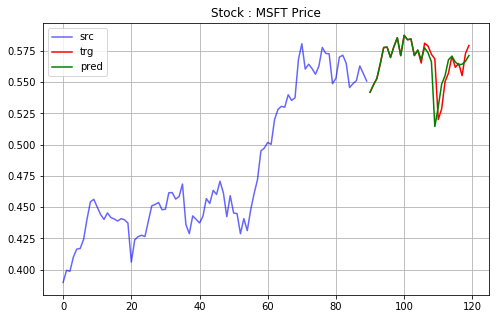

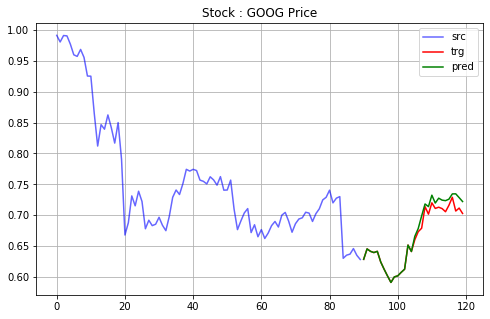

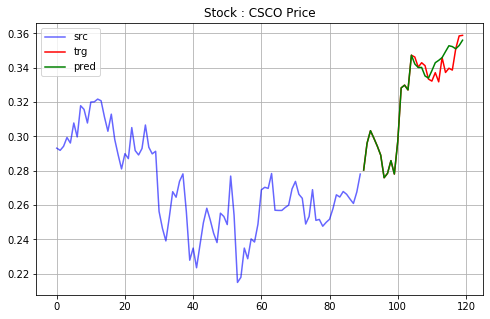

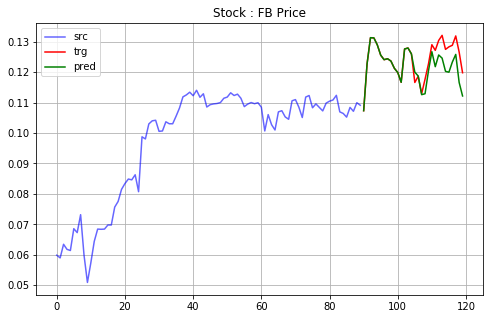

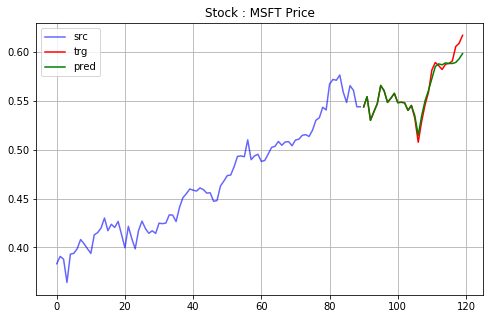

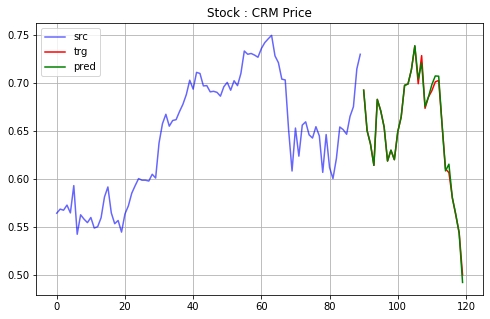

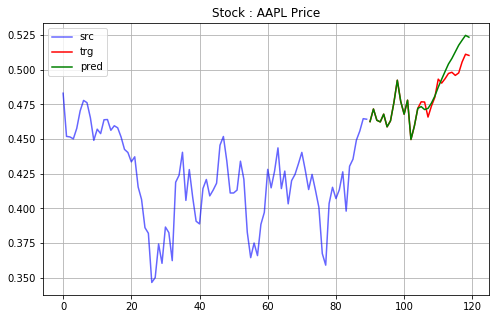

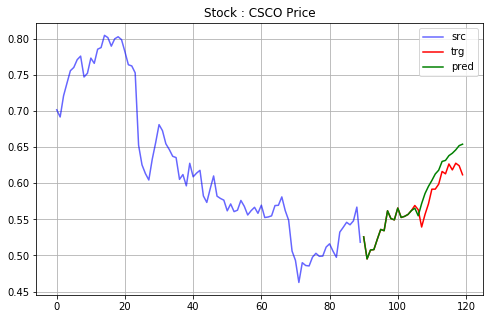

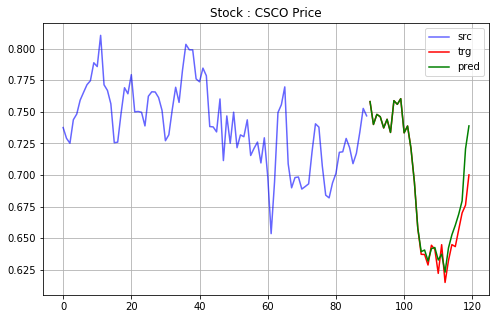

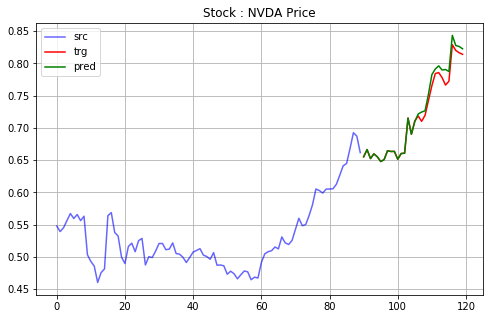

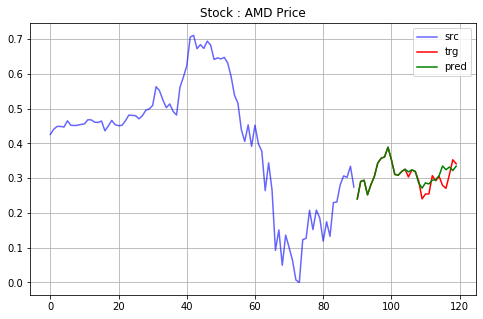

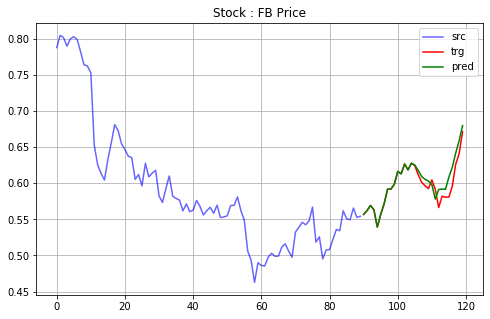

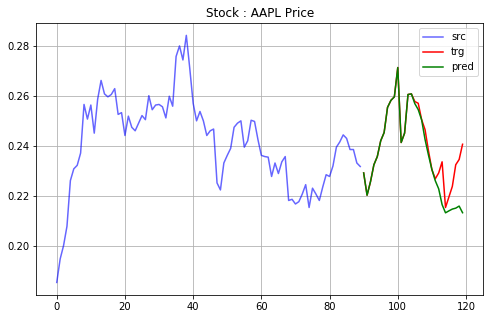

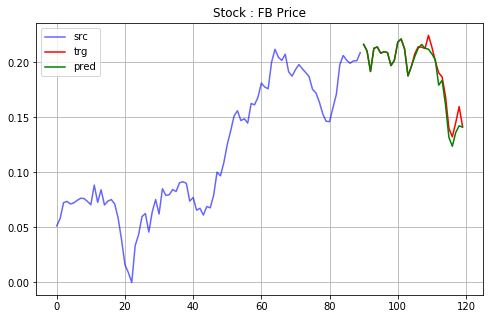

In [38]:
idx=np.random.randint(0,1000,30)

for i in idx:

    src = valloader.dataset[i]['src']
    trg = valloader.dataset[i]['trg']
#     print(f'trg:{trg}')
    stockname = data[i]['symbol']

#     mu = stockdict[stockname]['mean'].open
#     std = stockdict[stockname]['std'].open

    prediction = model_predict_padtrg(Transformer, src, trg,15)[:, :, 1]
    prediction = prediction.squeeze(1)
    prediction = prediction.detach().cpu().numpy()

#     prediction = (prediction*std)+mu
#     src = src*std+mu
#     trg = trg*std+mu

    draw_line_normalized_close(src, trg, stockname, prediction)
    plt.show()

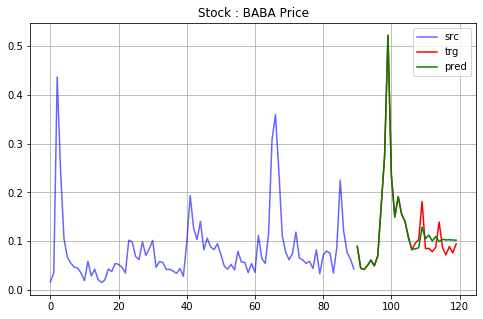

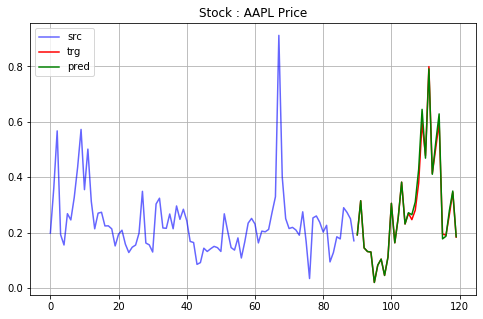

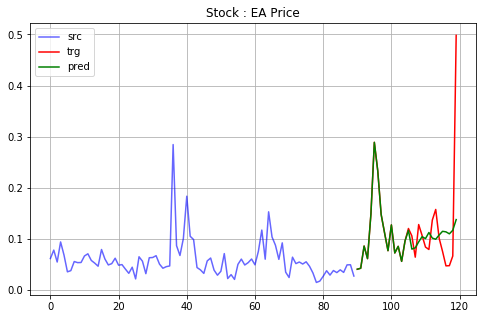

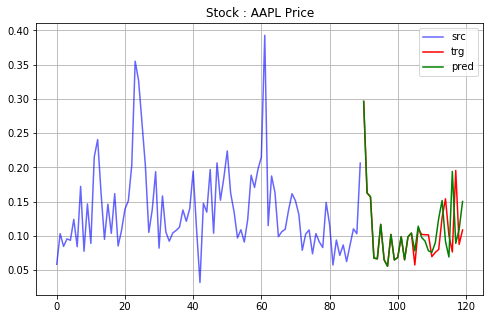

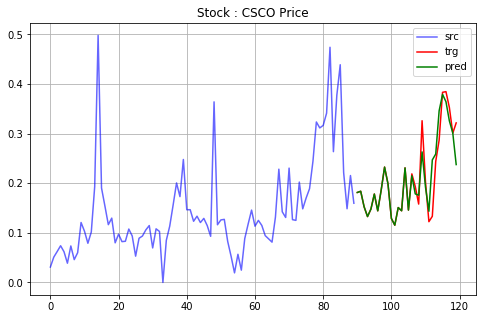

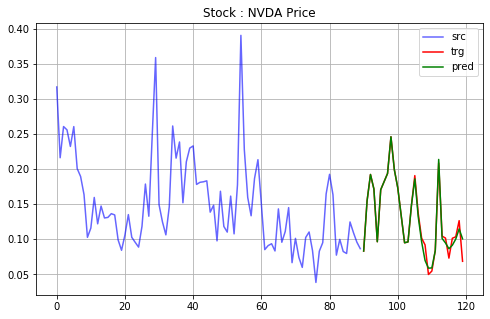

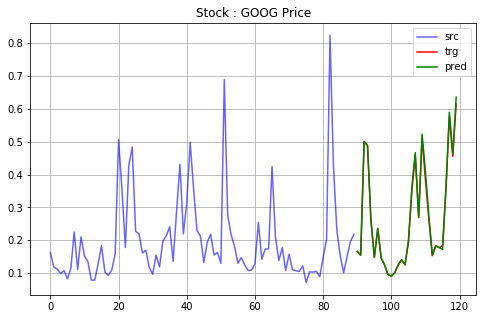

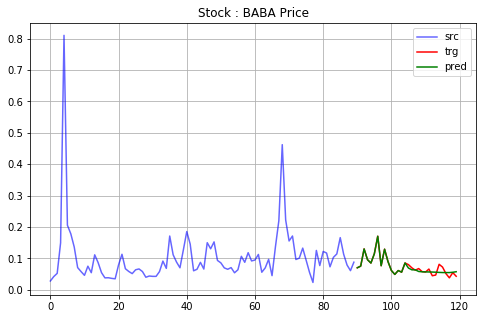

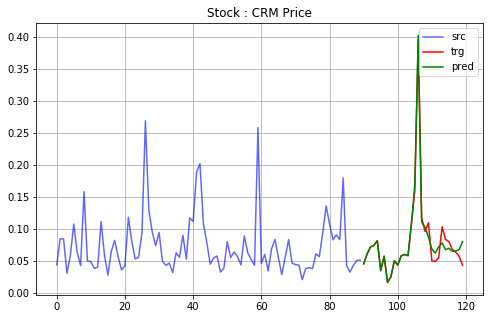

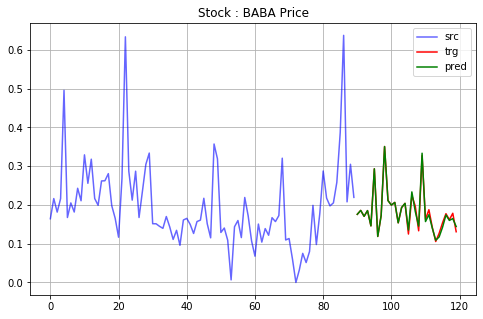

In [43]:
idx=np.random.randint(0,3000,10)

for i in idx:

    src = valloader.dataset[i]['src']
    trg = valloader.dataset[i]['trg']
#     print(f'trg:{trg}')
    stockname = data[i]['symbol']

#     mu = stockdict[stockname]['mean'].open
#     std = stockdict[stockname]['std'].open
#     print(trg)
    prediction = model_predict_padtrg(Transformer, src, trg,15)[:, :, 2]
    prediction = prediction.squeeze(1)
    prediction = prediction.detach().cpu().numpy()

#     prediction = (prediction*std)+mu
#     src = src*std+mu
#     trg = trg*std+mu

    draw_line_normalized_vol(src, trg, stockname, prediction)
    plt.show()

In [ ]:
for idx, sample in enumerate(trainloader):

    src = sample['src']
    trg = sample['trg']
    print(src.shape)
    print(trg.shape)
    print(trg[0,:,0]==src[0,0,-1])
    break

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(Transformer):,} trainable parameters')

In [ ]:
def lambda_rule(epoch, epoch_count1=1, epoch_count2=200):
    
    lr_l = 10

    if epoch-epoch_count1 < 0:
        lr_l = 1.0
        
    if epoch-epoch_count2>0:
        lr_l = 1.0
        

    return lr_l
scheduler = LambdaLR(optimizer, lr_lambda=lambda_rule)
for i in range(400):
    print(scheduler.get_last_lr())
    scheduler.step()

# Check gradient flow

In [ ]:
def plot_grad_flow(model):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in model.named_parameters():
#         if(p.requires_grad) and ("bias" not in n):
          if p.requires_grad:  
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    
